In [ ]:
%pip install torch
%pip install transformers
%pip install datasets
%pip install scikit-learn
%pip install nlpaug
%pip install seaborn

In [7]:
%pip install torch --index-url https://download.pytorch.org/whl/cu118 --force-reinstall --upgrade

Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 0.0/536.2 kB ? eta -:--:--
     ---------------------------------------- 536.2/536.2 kB 8.8 MB/s  0:00:00
   ---------------------------------------- 0.0/2.8 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 GB 985.5 kB/s eta 0:47:39
   ---------------------------------------- 0.0/2.8 GB 985.5 kB/s eta 0:47:39
   ---------------------------------------- 0.0/2.8 GB 2.3 MB/s eta 0:20:42
   ---------------------------------------- 0.0/2.8 GB 3.0 MB/s eta 0:15:40
   ---------------------------------------- 0.0/2.8 GB 3.8 MB/s eta 0:12:14
   ---------------------------------------- 0.0/2.8 GB 5.1 M

  You can safely remove it manually.
  You can safely remove it manually.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from transformers import DistilBertTokenizer
from src.dataset.process_data import load_dataset, calculate_class_weights
from src.training.train_bloombert import train_model_bloombert
from src.helper.plots_helper import plot_training_history

# CONFIGURE TORCH
torch.cuda.empty_cache()
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(1111)

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
print(f'-- Training on: {device}')

C:\Users\DURANO JOHN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-- Training on: cuda


In [4]:
print("-- Loading dataset")
df = load_dataset('data/blooms_dataset.csv', clean=True)
df = df.sort_values(by=['Label', 'Text'], ascending=[True, True])
df.to_csv('data/blooms_cleaned_dataset.csv', index=False)

print(df['Label'].value_counts().sort_index())

class_weights = calculate_class_weights(df["Label"].to_numpy()).to(device)
print(class_weights)

-- Loading dataset
Label
0    1532
1    2348
2     671
3     560
4     634
5     430
Name: count, dtype: int64
tensor([0.6718, 0.4383, 1.5338, 1.8378, 1.6233, 2.3934], device='cuda:0')


C:\Users\DURANO JOHN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\DURANO JOHN\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage i

Epoch 1: Train Loss=1.8702, Train Acc=0.1781, Val Loss=1.8622, Val Acc=0.2324


Epoch 2/50: 100%|██████████| 39/39 [00:03<00:00, 11.36it/s]


Epoch 2: Train Loss=1.8612, Train Acc=0.1970, Val Loss=1.8550, Val Acc=0.2389


Epoch 3/50: 100%|██████████| 39/39 [00:03<00:00, 11.48it/s]


Epoch 3: Train Loss=1.8568, Train Acc=0.2055, Val Loss=1.8480, Val Acc=0.2745


Epoch 4/50: 100%|██████████| 39/39 [00:03<00:00, 11.39it/s]


Epoch 4: Train Loss=1.8478, Train Acc=0.2296, Val Loss=1.8409, Val Acc=0.3004


Epoch 5/50: 100%|██████████| 39/39 [00:03<00:00, 11.50it/s]


Epoch 5: Train Loss=1.8423, Train Acc=0.2358, Val Loss=1.8338, Val Acc=0.3142


Epoch 6/50: 100%|██████████| 39/39 [00:05<00:00,  7.23it/s]


Epoch 6: Train Loss=1.8029, Train Acc=0.2824, Val Loss=1.7301, Val Acc=0.3830


Epoch 7/50: 100%|██████████| 39/39 [00:05<00:00,  7.14it/s]


Epoch 7: Train Loss=1.6466, Train Acc=0.4097, Val Loss=1.5057, Val Acc=0.5482


Epoch 8/50: 100%|██████████| 39/39 [00:05<00:00,  7.09it/s]


Epoch 8: Train Loss=1.4080, Train Acc=0.5862, Val Loss=1.2773, Val Acc=0.6761


Epoch 9/50: 100%|██████████| 39/39 [00:05<00:00,  7.12it/s]


Epoch 9: Train Loss=1.2022, Train Acc=0.7043, Val Loss=1.1145, Val Acc=0.7190


Epoch 10/50: 100%|██████████| 39/39 [00:05<00:00,  7.14it/s]


Epoch 10: Train Loss=1.0587, Train Acc=0.7575, Val Loss=1.0246, Val Acc=0.7433


Epoch 11/50: 100%|██████████| 39/39 [00:05<00:00,  7.12it/s]


Epoch 11: Train Loss=0.9818, Train Acc=0.7885, Val Loss=0.9695, Val Acc=0.7717


Epoch 12/50: 100%|██████████| 39/39 [00:05<00:00,  7.14it/s]


Epoch 12: Train Loss=0.9189, Train Acc=0.8089, Val Loss=0.9334, Val Acc=0.7830


Epoch 13/50: 100%|██████████| 39/39 [00:05<00:00,  7.15it/s]


Epoch 13: Train Loss=0.8872, Train Acc=0.8267, Val Loss=0.9085, Val Acc=0.7984


Epoch 14/50: 100%|██████████| 39/39 [00:05<00:00,  7.30it/s]


Epoch 14: Train Loss=0.8496, Train Acc=0.8421, Val Loss=0.8852, Val Acc=0.8105


Epoch 15/50: 100%|██████████| 39/39 [00:05<00:00,  7.33it/s]


Epoch 15: Train Loss=0.8189, Train Acc=0.8528, Val Loss=0.8682, Val Acc=0.8162


Epoch 16/50: 100%|██████████| 39/39 [00:05<00:00,  7.29it/s]


Epoch 16: Train Loss=0.8054, Train Acc=0.8603, Val Loss=0.8525, Val Acc=0.8316


Epoch 17/50: 100%|██████████| 39/39 [00:05<00:00,  7.32it/s]


Epoch 17: Train Loss=0.7919, Train Acc=0.8682, Val Loss=0.8391, Val Acc=0.8340


Epoch 18/50: 100%|██████████| 39/39 [00:05<00:00,  7.29it/s]


Epoch 18: Train Loss=0.7674, Train Acc=0.8747, Val Loss=0.8276, Val Acc=0.8502


Epoch 19/50: 100%|██████████| 39/39 [00:05<00:00,  7.37it/s]


Epoch 19: Train Loss=0.7488, Train Acc=0.8874, Val Loss=0.8196, Val Acc=0.8543


Epoch 20/50: 100%|██████████| 39/39 [00:05<00:00,  7.31it/s]


Epoch 20: Train Loss=0.7447, Train Acc=0.8901, Val Loss=0.8101, Val Acc=0.8599


Epoch 21/50: 100%|██████████| 39/39 [00:05<00:00,  7.36it/s]


Epoch 21: Train Loss=0.7333, Train Acc=0.8947, Val Loss=0.8008, Val Acc=0.8599


Epoch 22/50: 100%|██████████| 39/39 [00:05<00:00,  7.37it/s]


Epoch 22: Train Loss=0.7199, Train Acc=0.9028, Val Loss=0.7994, Val Acc=0.8623


Epoch 23/50: 100%|██████████| 39/39 [00:05<00:00,  7.30it/s]


Epoch 23: Train Loss=0.7130, Train Acc=0.9055, Val Loss=0.7920, Val Acc=0.8664


Epoch 24/50: 100%|██████████| 39/39 [00:05<00:00,  7.35it/s]


Epoch 24: Train Loss=0.7037, Train Acc=0.9107, Val Loss=0.7923, Val Acc=0.8664


Epoch 25/50: 100%|██████████| 39/39 [00:05<00:00,  7.34it/s]


Epoch 25: Train Loss=0.6964, Train Acc=0.9105, Val Loss=0.7866, Val Acc=0.8721


Epoch 26/50: 100%|██████████| 39/39 [00:05<00:00,  7.34it/s]


Epoch 26: Train Loss=0.6917, Train Acc=0.9174, Val Loss=0.7809, Val Acc=0.8753


Epoch 27/50: 100%|██████████| 39/39 [00:05<00:00,  7.36it/s]


Epoch 27: Train Loss=0.6836, Train Acc=0.9178, Val Loss=0.7829, Val Acc=0.8761


Epoch 28/50: 100%|██████████| 39/39 [00:05<00:00,  7.35it/s]


Epoch 28: Train Loss=0.6783, Train Acc=0.9204, Val Loss=0.7838, Val Acc=0.8729


Epoch 29/50: 100%|██████████| 39/39 [00:05<00:00,  7.34it/s]


Epoch 29: Train Loss=0.6715, Train Acc=0.9241, Val Loss=0.7766, Val Acc=0.8834


Epoch 30/50: 100%|██████████| 39/39 [00:05<00:00,  7.35it/s]


Epoch 30: Train Loss=0.6681, Train Acc=0.9296, Val Loss=0.7791, Val Acc=0.8769


Epoch 31/50: 100%|██████████| 39/39 [00:06<00:00,  6.15it/s]


Epoch 31: Train Loss=0.6594, Train Acc=0.9300, Val Loss=0.7767, Val Acc=0.8826


Epoch 32/50: 100%|██████████| 39/39 [00:06<00:00,  6.13it/s]


Epoch 32: Train Loss=0.6515, Train Acc=0.9364, Val Loss=0.7749, Val Acc=0.8899


Epoch 33/50: 100%|██████████| 39/39 [00:06<00:00,  6.15it/s]


Epoch 33: Train Loss=0.6465, Train Acc=0.9379, Val Loss=0.7685, Val Acc=0.8923


Epoch 34/50: 100%|██████████| 39/39 [00:06<00:00,  6.14it/s]


Epoch 34: Train Loss=0.6418, Train Acc=0.9447, Val Loss=0.7710, Val Acc=0.8891


Epoch 35/50: 100%|██████████| 39/39 [00:06<00:00,  6.11it/s]


Epoch 35: Train Loss=0.6366, Train Acc=0.9466, Val Loss=0.7705, Val Acc=0.8955


Epoch 36/50: 100%|██████████| 39/39 [00:06<00:00,  6.14it/s]


Epoch 36: Train Loss=0.6275, Train Acc=0.9524, Val Loss=0.7649, Val Acc=0.8955


Epoch 37/50: 100%|██████████| 39/39 [00:06<00:00,  6.14it/s]


Epoch 37: Train Loss=0.6260, Train Acc=0.9569, Val Loss=0.7681, Val Acc=0.8964


Epoch 38/50: 100%|██████████| 39/39 [00:06<00:00,  6.10it/s]


Epoch 38: Train Loss=0.6206, Train Acc=0.9632, Val Loss=0.7709, Val Acc=0.8931


Epoch 39/50: 100%|██████████| 39/39 [00:06<00:00,  6.09it/s]


Epoch 39: Train Loss=0.6186, Train Acc=0.9611, Val Loss=0.7719, Val Acc=0.9045


Epoch 40/50: 100%|██████████| 39/39 [00:06<00:00,  6.13it/s]


Epoch 40: Train Loss=0.6112, Train Acc=0.9646, Val Loss=0.7692, Val Acc=0.9053


Epoch 41/50: 100%|██████████| 39/39 [00:06<00:00,  6.13it/s]


Epoch 41: Train Loss=0.6100, Train Acc=0.9674, Val Loss=0.7727, Val Acc=0.8988


Epoch 42/50: 100%|██████████| 39/39 [00:06<00:00,  6.14it/s]


Epoch 42: Train Loss=0.6073, Train Acc=0.9706, Val Loss=0.7765, Val Acc=0.8980


Epoch 43/50: 100%|██████████| 39/39 [00:06<00:00,  6.10it/s]


Epoch 43: Train Loss=0.6044, Train Acc=0.9737, Val Loss=0.7732, Val Acc=0.9004


Epoch 44/50: 100%|██████████| 39/39 [00:06<00:00,  6.14it/s]


Epoch 44: Train Loss=0.6007, Train Acc=0.9755, Val Loss=0.7763, Val Acc=0.9012


Epoch 45/50: 100%|██████████| 39/39 [00:06<00:00,  6.13it/s]


Epoch 45: Train Loss=0.5987, Train Acc=0.9759, Val Loss=0.7763, Val Acc=0.8980


Epoch 46/50: 100%|██████████| 39/39 [00:06<00:00,  6.14it/s]


Epoch 46: Train Loss=0.5935, Train Acc=0.9820, Val Loss=0.7800, Val Acc=0.9004


Epoch 47/50: 100%|██████████| 39/39 [00:06<00:00,  6.10it/s]


Epoch 47: Train Loss=0.5921, Train Acc=0.9814, Val Loss=0.7773, Val Acc=0.9045


Epoch 48/50: 100%|██████████| 39/39 [00:06<00:00,  6.11it/s]


Epoch 48: Train Loss=0.5900, Train Acc=0.9850, Val Loss=0.7793, Val Acc=0.8931


Epoch 49/50: 100%|██████████| 39/39 [00:06<00:00,  6.13it/s]


Epoch 49: Train Loss=0.5854, Train Acc=0.9866, Val Loss=0.7779, Val Acc=0.8980


Epoch 50/50: 100%|██████████| 39/39 [00:06<00:00,  6.11it/s]


Epoch 50: Train Loss=0.5841, Train Acc=0.9864, Val Loss=0.7843, Val Acc=0.8988


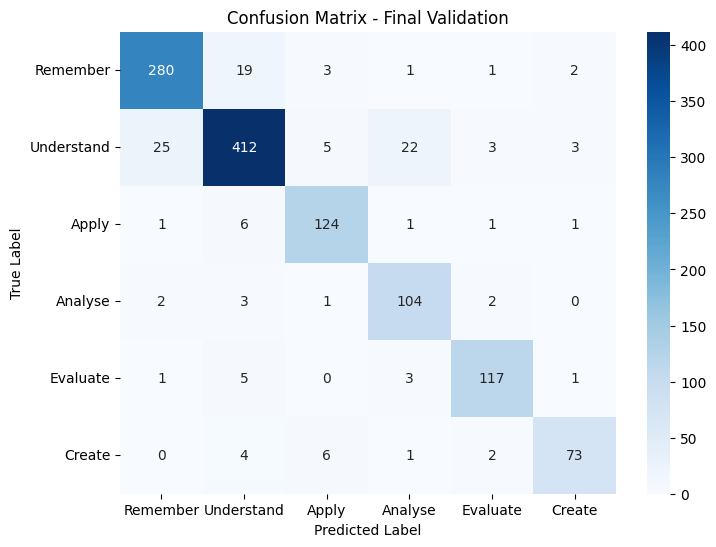

In [5]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

config = {
    "learning_rate": 1e-5,
    "batch_size": 128,
    "epochs": 50,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

class_weights = calculate_class_weights(df["Label"].to_numpy()).to(config["device"])

best_model, history, best_val_acc = train_model_bloombert(
    df,
    tokenizer,
    config,
    class_weights=class_weights,
    test_size=0.2,
    augment=False
)

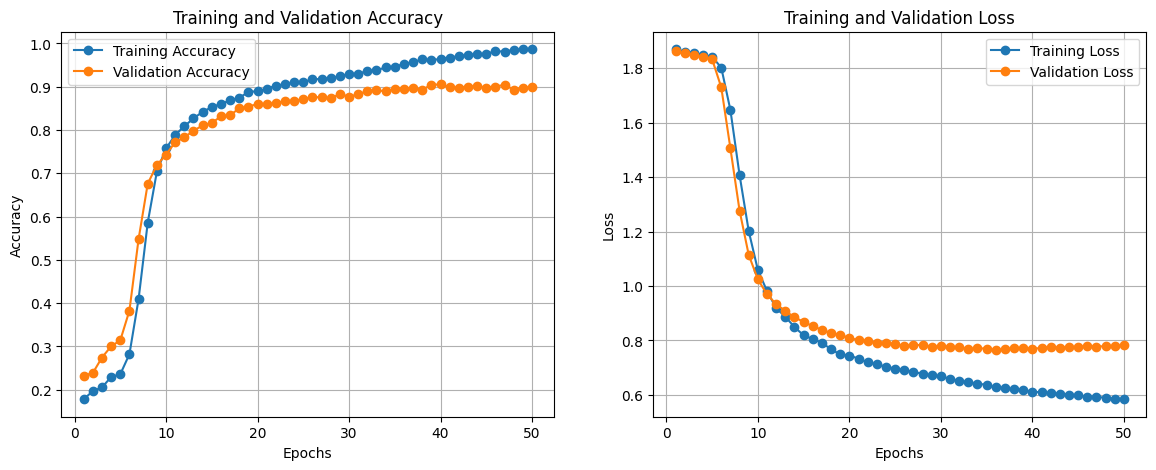

In [6]:
plot_training_history(history)

In [8]:
# save best model
torch.save(best_model.state_dict(), "model/bloombert_model.pt")

# Load trained model

In [9]:
from src.model.bloombert import BloomBERT

config = {
    # "learning_rate": 1e-5,
    # "batch_size": 128,
    # "epochs": 50,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# load model
best_model = BloomBERT(output_dim=6).to(config["device"])
best_model.load_state_dict(torch.load("model/bloombert_model.pt", map_location=config["device"]))
best_model.eval()

BloomBERT(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_fe

In [10]:
import numpy as np
np.set_printoptions(suppress=True, precision=4)

texts = [
    "remember the main point of the lesson",
    "apply the concept to solve a problem",
    "develop new project ideas",
]

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
encodings = tokenizer(texts, truncation=True, padding=True, return_tensors="pt")

input_ids = encodings["input_ids"].to(device)
attention_mask = encodings["attention_mask"].to(device)

best_model.eval()

with torch.no_grad():
    prob_ge = best_model(input_ids=input_ids, attention_mask=attention_mask)

print("prob_ge outputs:")
print(prob_ge)

prob_ge_np = prob_ge.cpu().numpy()
print(prob_ge_np)

prob_ge outputs:
tensor([[ 2.4631, -1.9875, -0.1692, -0.3792, -0.5643, -0.1606],
        [-1.0568, -2.4535,  3.1939, -0.4519, -0.9874, -0.2521],
        [-1.0140, -1.8126, -0.6433,  0.6670, -0.4113,  4.5203]],
       device='cuda:0')
[[ 2.4631 -1.9875 -0.1692 -0.3792 -0.5643 -0.1606]
 [-1.0568 -2.4535  3.1939 -0.4519 -0.9874 -0.2521]
 [-1.014  -1.8126 -0.6433  0.667  -0.4113  4.5203]]


In [17]:
category_dict = {
    0: "Remember",
    1: "Understand",
    2: "Apply",
    3: "Analyse",
    4: "Evaluate",
    5: "Create"
}

def predict_blooms(text, model, tokenizer, device):
    encodings = tokenizer(text, truncation=True, padding=True, return_tensors="pt")
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[0]
        pred_class = int(torch.argmax(outputs, dim=1).cpu().numpy()[0])
    
    return category_dict[pred_class], probs

In [18]:
test_text = "Brainstorm a new market strategy to expand in Asia"
predicted_class, probabilities = predict_blooms(test_text, best_model, tokenizer, config["device"])

print("Text:", test_text)
print("Predicted Class:", predicted_class)
print("Probabilities:", probabilities)

Text: Brainstorm a new market strategy to expand in Asia
Predicted Class: Create
Probabilities: [0.0047 0.0029 0.0132 0.011  0.0098 0.9584]
